# How does the scattering matrix compare to Feautrier?

Let's run a couple of tests to see how these two compare. First we need to load up our tools.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import objects as rt
import pyauric

## Running AURIC

First, we need to run the AURIC model and get some profiles for the 83.4 nm triplet.

In [2]:
# set up an AURIC manager for this working directory
auric=pyauric.AURICManager('.')
!cp $AURIC_ROOT/param.inp ./param.inp

# run AURIC
auric.runbatch()

# grab auric's ionosphere and neutrals
edp = auric.retrieve( 'ionos.dat', features=['[e-]'] )
neutrals = auric.retrieve( 'atmos.dat', features=['Tn (K)','[O]','[N2]','[O2]'] )

Plot the output to make sure the AURIC data is actually there and makes sense.

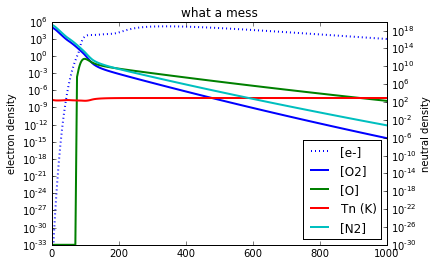

In [3]:
def plot_auric( ax, d, sum_triplet=False, **kwargs ):
    lines = []
    # is it an altitude or zenith angle profile?
    if len(d['ALT']):
        x = d['ALT']
    else:
        x = d['ZA']
    # plot 'em
    for key in d:
        if key not in ['ALT','ZA']:                
            lines.extend( ax.plot( x, d[key], label=key, **kwargs ) )
    return lines

fig = plt.figure()
ax1 = fig.gca()
ax1.set_yscale('log')
ax1.set_ylabel('electron density')
ax2 = ax1.twinx()
ax2.set_ylabel('neutral density')
ax2.set_xlabel('altitude')
ax2.set_yscale('log')

style = {'lw':2, 'alpha':1}
lines = plot_auric( ax1, edp, ls=':', **style )
morelines = plot_auric( ax2, neutrals, **style )
lines+=morelines
labels = [l.get_label() for l in lines]
ax2.set_title("what a mess")
ax2.legend(lines, labels, loc="lower right", framealpha=1.0);

The graph above should look cluttered, but physical. 

Now, let's run the AURIC `radtrans` module to get a scattered 83.4 nm profile. This code is Dr. Randy Gladstone's REDISTER, according to the AURIC User's Manual. The radiative transfer options are configured with a series of `ON|OFF` switches stored in `raptrans.opt`. After `radtrans`, we can run `losint` to get line-of-sight intensities like the output of vickers' code.

In [4]:
rt_options={'832':'ON','833':'ON','834':'ON'}
auric.write( "radtrans.opt", options=rt_options )
oldh, za = auric.read('view.inp')
h=340 #km
auric.write('view.inp', h=h, za=za )

# let's check those settings.
!awk '2<NR && 6>NR' radtrans.opt
!awk '1==NR' view.inp

         832  = ON
         833  = ON
         834  = ON
   340.0000   observer altitude (km)


In [5]:
# run the feautrier code
!rm dglthick.int
!sleep 2
auric.customrun(['radtrans','losint'])
!sleep 2

Let's compare the profile before and after radiative transfer is calculated.

In [6]:
!!grep "83[234] A .initial." dayglo.ver

['O+e 832 A (initial)',
 'O+e 833 A (initial)',
 'O+e 834 A (initial)',
 'O+hv 832 A (initial)',
 'O+hv 833 A (initial)',
 'O+hv 834 A (initial)']

In [7]:
!!grep "83[234] A .final." dayglo.ver

['832 A (final)', '833 A (final)', '834 A (final)']

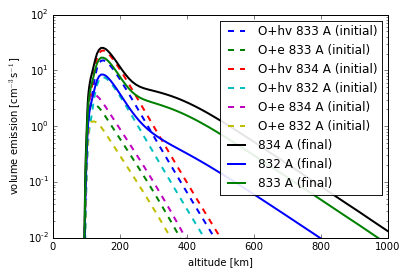

In [8]:
thin = __
thick = _
profthin = auric.retrieve( 'dayglo.ver', features=thin )
profthick = auric.retrieve( 'dayglo.ver', features=thick )
# for later use I will also grab the line-of-sight integrals
other_thick = ['83'+str(n)+' A' for n in [2,3,4]]
thicklos = auric.retrieve( 'dglthick.int', features=other_thick )

fig = plt.figure()
ax = fig.gca()
lines = plot_auric(ax, profthin, ls='--', **style )
lines+= plot_auric(ax, profthick, **style )
ax.set_yscale('log')
ax.set_ylim((0.01,100))
ax.set_ylabel(r'volume emission [cm$^{-3}$s$^{-1}$]')
ax.set_xlabel(r'altitude [km]')
ax.legend();

Vickers' code needs 91 evenly spaced altitudes, so we need to interpolate all of the AURIC functions before we can use them. This is easy to do  with  `scipy.interpolate.griddata`.

In [9]:
import scipy.interpolate
alts = np.linspace(100,1000,num=91)


iono = scipy.interpolate.griddata( edp['ALT'], edp['[e-]'], alts )

def interp_n(y): 
    return scipy.interpolate.griddata( neutrals['ALT'], y, alts )
neut = { k : interp_n(v) for (k,v) in neutrals.iteritems() if (k is not 'ALT' and k is not 'ZA') }

def interp_s(y): 
    return scipy.interpolate.griddata( profthin['ALT'], y, alts )
src = { k : interp_s(v) for (k,v) in profthin.iteritems() if (k is not 'ALT' and k is not 'ZA') }

Currently, the vickers manager need things to be wrapped in `rt_tools` objects. This was probably a bit overzealous on my part, and I will change it eventually. For now, we just have a little bit more setup to go. 

Also, it comes to my attention now that we sum the source profiles before passing them to vickers RT. **This is flat-out wrong.** I wonder how much we can improve by not doing this...

In [10]:
thin

['O+e 832 A (initial)',
 'O+e 833 A (initial)',
 'O+e 834 A (initial)',
 'O+hv 832 A (initial)',
 'O+hv 833 A (initial)',
 'O+hv 834 A (initial)']

static_functions.py:57: RuntimeWarning: invalid value encountered in arccos
  angleoglobe = np.arccos((RE+np.array(tanptalt))/(RE+h))


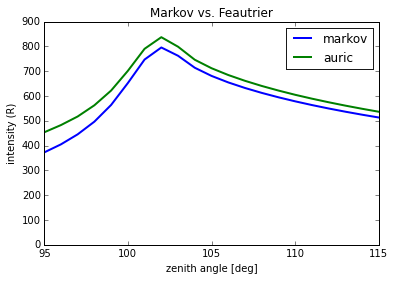

In [11]:
rtpath='../../../jsv_rt_cython/RT/' #this might change depending on your directory setup!
import gsrp
model=rt.gsrpManager(rtpath, gsrp)

# wrappers for all...
msis = rt.MSIS( alts, neut["Tn (K)"], neut["[O]"], neut["[N2]"], neut["[O2]"] )
ionosphere = rt.Density(alts,iono)
SUM=src['O+hv 832 A (initial)']+src['O+hv 833 A (initial)']+src['O+hv 834 A (initial)']
SUM=SUM+src['O+e 832 A (initial)']+src['O+e 833 A (initial)']+src['O+e 834 A (initial)']
sourcef = rt.Emission(alts, SUM )

# safe-method='extend_top' puts a smooth exponential decay from the last data point to 1000 km.
zt = model.runRT( h, msis, ionosphere, sourcef, safe_method="extend_top" )

#convert units before plotting
zt.convert('rayleighs')

fig = plt.figure()
ax = fig.gca()
def plot_vickers( ax, Z, **kwargs ):
    lines = ax.plot(Z.za+1, Z.values, **kwargs )
    ax.set_ylabel('intensity (R)')
    ax.set_xlabel('zenith angle [deg]')
    return lines
lines = plot_vickers( ax, zt, label='markov', **style )
ax.set_title("Markov vs. Feautrier")

auric834 = thicklos['832 A']+thicklos['833 A']+thicklos['834 A']
lines+= ax.plot( thicklos['ZA'], auric834, label='auric', **style )
ax.set_xlim( (thicklos["ZA"][0],thicklos["ZA"][-1]) )
leg = ax.legend(loc='best')

fig.savefig("../figures/AURICvsMATRIX.eps")

## The Fudge Factor

Not too bad, but missing quite a lot at low angles. In order to make it work we need to apply a fudge factor. *What is wrong here? *

It must be some space weather parameter that is thowing this off. Ewan pointed out that the temperature will cahnge the balance of the three lines in the triplet. Could this be it?

Could it be as simple as scaling the source inputs according to their geometric ratios?

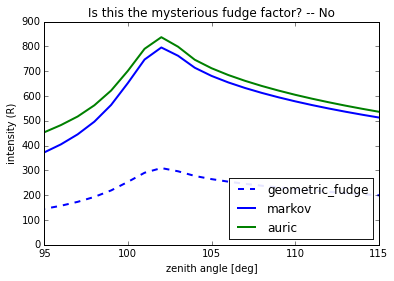

In [12]:
gsrc = 1/6.*(src['O+hv 832 A (initial)'] + src['O+e 832 A (initial)'] )
gsrc = gsrc + 1/3.*(src['O+hv 833 A (initial)'] + src['O+e 833 A (initial)'] )
gsrc = gsrc + 1/2.*(src['O+hv 834 A (initial)'] + src['O+e 834 A (initial)'] )
geometric_source = rt.Emission( alts, gsrc )

ztg = model.runRT( h, msis, ionosphere, geometric_source, safe_method="extend_top" )
ztg.convert('rayleighs')

fig = plt.figure()
ax = fig.gca()
lines = plot_vickers( ax, ztg, label='geometric_fudge', ls='--', **style )
ax.set_title("Is this the mysterious fudge factor? -- No")

lines+= plot_vickers( ax, zt, label='markov', color='b', **style )
lines+= ax.plot( thicklos['ZA'], auric834, label='auric', color='g', **style )
ax.set_xlim( (95,115) )
leg = ax.legend(loc='lower right')

This is definitely not it. However, it would be interesting to see what happens if we actually pass in three sources to vickers' code. Also, the copy I have currently assumes a constant temperature of 1000 K regardless of the MSIS values we pass. :O 

In [13]:
!grep -n "TEM" /home/geddes/projects/RAIDS/jsv_rt_cython/RT/gsrp.c

302:     set_element(MSIS,row,TEM,1000.0);
820:   temp  = get_element(MSIS,i,TEM);
847:   temp  = get_element(MSIS,i,TEM);


## Adjusting space weather

In past experience, the agreement of the two models depends quite a bit on space weather conditions. Let's take a look at what we've been working with. F10.7 should be the main parameter to care about here.

In [14]:
!grep '.*F10.*' param.inp

      F10DAY =      90.70 : F10.7 (current day)
      F10PRE =      79.70 : F10.7 (previous day)
      F10AVE =      80.90 : F10.7 (81-day average)


Let's vary F10.7 and see how the two models change.

In [16]:
def F107ify( F107 ):
    return { key : F107 for key in ['F10DAY','F10PRE'] }        

def sum_lines(d):
    SUM=0
    for key in d:
        if key not in ['ALT','ZA','label','run']:                
            SUM = SUM + d[key]
    return SUM

def all_in_one_vickers():
    h = auric.read('view.inp')[0]
    edp = auric.retrieve( 'ionos.dat', features=['[e-]'] )
    neutrals = auric.retrieve( 'atmos.dat', features=['Tn (K)','[O]','[N2]','[O2]'] )
    profthin = auric.retrieve( 'dayglo.ver', features=thin )
    iono = scipy.interpolate.griddata( edp['ALT'], edp['[e-]'], alts )
    neut = { k : interp_n(v) for (k,v) in neutrals.iteritems() if (k is not 'ALT' and k is not 'ZA') }
    src = { k : interp_s(v) for (k,v) in profthin.iteritems() if (k is not 'ALT' and k is not 'ZA') }
    msis = rt.MSIS( alts, neut["Tn (K)"], neut["[O]"], neut["[N2]"], neut["[O2]"] )
    ionosphere = rt.Density(alts,iono)
    SUM=src['O+hv 832 A (initial)']+src['O+hv 833 A (initial)']+src['O+hv 834 A (initial)']
    SUM=SUM+src['O+e 832 A (initial)']+src['O+e 833 A (initial)']+src['O+e 834 A (initial)']
    sourcef = rt.Emission(alts, SUM )
    zt=model.runRT( h, msis, ionosphere, sourcef, safe_method="extend_top" )
    zt.convert('rayleighs')
    return zt

F107_vals = np.hstack([np.linspace(50,100,5),np.linspace(110,150,10)])

sources = []
auric_runs = []
vickers_runs = []
for F107 in F107_vals:
    auric.set_params( F107ify( F107 ) )
    auric.runbatch()
    sources.append( auric.retrieve( 'dayglo.ver', thin ) )
    run = auric.retrieve( 'dglthick.int', other_thick )
    run['label'] = F107
    run['sum'] = sum_lines(run)
    auric_runs.append( run )
    vickers_runs.append( all_in_one_vickers() )

Plot the difference between the two:

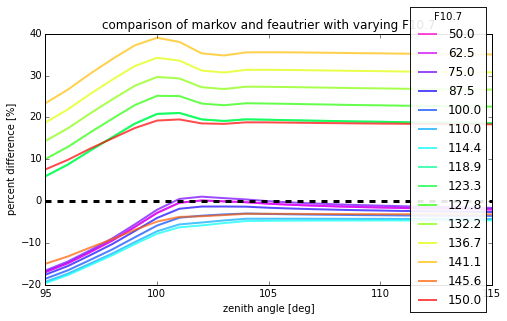

In [17]:
import matplotlib.cm as cm
fig = plt.figure( figsize=(8,4.5) )
ax = fig.gca()
ax.hlines( 0, 95, 115, color='k', linestyles='dashed' )

def compare_runs( a, v, N, color=(lambda i: cm.hsv(i)), **kwargs):
    i=float(N)
    lines=[]
    for A,V in zip(a,v):
        i-=1.
        x = V.za+1
        A_interp = scipy.interpolate.griddata( A['ZA'], A['sum'], x )
        y = 100*(V.values - A_interp)/A_interp
        lines+= ax.plot( x, y, label=np.round(A['label'],1), color=color(i/(N+1)), zorder=-i,**kwargs)
        ax.set_xlabel('zenith angle [deg]')
        ax.set_ylabel('percent difference [%]')
    return lines
lines = compare_runs( auric_runs, vickers_runs, len(F107_vals), lw=2, alpha=0.7 )
ax.set_title('comparison of markov and feautrier with varying F10.7')
leg = ax.legend( title='F10.7', loc='center right')
fig.savefig('../figures/F107comparison.eps')

This plot has been acting a bit weird. It changes each time I run it. I should probably sleep now anyway. 

-My best guess for how to bring the two models more in line is to pass vickers three separate source functions.

-The falloff of the vickers profiles at low zenith angle (high altitude) is probably something to do with the equal altitude binning, I think.

-Another thing to try is using actual SW parameters from real days, but it is harder to get them nicely spaced.

## Realistic Space Weather

Let's try using actual space weather for this comparison. There is some stored in a file.

In [18]:
import datetime
import cPickle as pickle
SW = rt.SpaceWeather.fromtxt('sw20070101.txt')
base=datetime.datetime(2010,1,1,12)

# make a list of noon each day in 2010
daylist = [ base+datetime.timedelta(days=x) for x in range(365) ]

sw_to_params={}

rosettastone={'Avg_Ap':'AP(1)','F107Obs':'F10DAY','F107Lst81Obs':'F10AVE'}
sources2010 = []
auric_runs2010 = []
vickers_runs2010 = []

def year_comparison():
    sources2010 = []
    auric_runs2010 = []
    vickers_runs2010 = []
    f107pre = 75.
    for day in daylist:
        sw={ p:SW( day, p ) for p in rosettastone }
        pd = {'GLAT':42.6, 'GLON':288.5, 'GMLAT':53.2, 'GMLON':6.1, 'DPANG':72.0}
        pd['F10PRE']=f107pre
        for k,v in rosettastone.iteritems():
            pd[v]=sw[k]
        f107pre=sw['F107Obs']
        auric.set_params( pd )
        auric.runbatch()
        !sleep 1
        sources2010.append( auric.retrieve( 'dayglo.ver', thin ) )
        run = auric.retrieve( 'dglthick.int', other_thick )
        run['label'] = F107
        run['sum'] = sum_lines(run)
        auric_runs2010.append( run )
        vickers_runs2010.append( all_in_one_vickers() )

    with open( '2010comparsion.pkl', 'w' ) as f:
        pickle.dump( [ sources2010, vickers_runs2010, auric_runs2010 ] , f )
    return sources2010, vickers_runs2010, auric_runs2010

try:
#     raise Exception()
    with open( '2010comparsion.pkl', 'r' ) as f:
        data = pickle.load(f)
        sources2010, vickers_runs2010, auric_runs2010 = data[0], data[1], data[2]
except:
    sources2010, vickers_runs2010, auric_runs2010 = year_comparison()

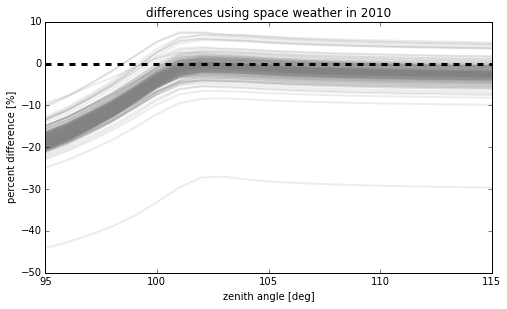

In [19]:
fig = plt.figure( figsize=(8,4.5) )
ax = fig.gca()
ax.hlines( 0, 95, 115, color='k', linestyles='dashed' )
def cf(i):
    return 'gray'
lines = compare_runs( auric_runs2010, vickers_runs2010, 365, color=cf, lw=2, alpha=0.15 )
ax.set_title( 'differences using space weather in 2010' );
fig.savefig('../figures/sw2010comparison.eps')

# Speed Testing

The ipython magic functions make this part super easy. First, let's time the vickers code.

## Timing Vickers:

In [20]:
%timeit zt = model.runRT( h, msis, ionosphere, sourcef, safe_method="extend_top" )

1 loops, best of 3: 217 ms per loop


## Timing Gladstone:

In [21]:
print 'radtrans time:'
!time $AURIC_ROOT/bin/`uname`/radtrans 1>/dev/null
print '\nlosint time:'
!time $AURIC_ROOT/bin/`uname`/losint 1>/dev/null

radtrans time:
1.28user 0.00system 0:01.29elapsed 100%CPU (0avgtext+0avgdata 8440maxresident)k
0inputs+224outputs (0major+655minor)pagefaults 0swaps

losint time:
FORTRAN STOP
0.05user 0.00system 0:00.05elapsed 98%CPU (0avgtext+0avgdata 1108maxresident)k
0inputs+48outputs (0major+330minor)pagefaults 0swaps


## <span style="color:red">Other ways to time this that might not be reliable:</span>

Try to get a time for AURIC's `radtrans; losint` using the `pyauric` helper.

In [22]:
%timeit auric.customrun(['radtrans','losint']) 

10 loops, best of 3: 109 ms per loop


I think the `%timeit` magic just doesn't time threaded processes correctly. When running an auric batch run at the command line, radtrans clearly takes about a second (granted that is with terminal output). Also, I had some weird issues when I used this command above that were fixed by sprinkling in some "`!sleep 1`"'s. Compare with the system `time` below.

I wonder if the python `time` package gets it right?

In [23]:
%%timeit import time
tic=time.time()
auric.customrun(['radtrans','losint'])
toc=time.time()
print "{:>1.4f} ".format(toc-tic),

0.1523  0.1264  0.1711  0.1794  0.1235  0.1221  0.1664  0.1645  0.1443  0.1075  0.1886  0.1507  0.1703  0.1500  0.1867  0.1363  0.1073  0.1392  0.1517  0.1375  0.0997  0.1166  0.1673  0.1820  0.1326  0.1795  0.1856  0.1757  0.2390  0.1927  0.1512  0.1551  0.1597  0.1874  0.2072  0.2375  0.1492  0.1555  0.2312  0.1551  0.2692 10 loops, best of 3: 144 ms per loop



This is way too short. I trust the system time much more. 

In [24]:
%%file auric.sh
#!/bin/bash
$AURIC_ROOT/bin/`uname`/radtrans
$AURIC_ROOT/bin/`uname`/losint

Overwriting auric.sh


In [25]:
!chmod 755 auric.sh

In [26]:
%timeit !./auric.sh 1>/dev/null 2>/dev/null

1 loops, best of 3: 2.06 s per loop


Huh, this is longer than the system time by more than I expected, but still closer than the threaded version. 